In [1]:
%matplotlib inline
#TODO: cleanup imports
import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime

import sys 
sys.path.append('../Python-modules/') #For bee_helpers and file_helpers 
from bee_helpers import calc_trip_lengths, calc_trip_starts, get_forager_bee_ids, get_random_bee_ids, get_all_bee_ids
from file_helpers import cache_location_prefix, detections_to_presence, detections_to_presence_locations, create_presence_cache_filename, create_presence_locations_cache_filename, create_presence_cache_filename, cache_location_prefix, create_presence_locations_cam_cache_filename
import time

from tqdm import tqdm_notebook
from tqdm import tqdm
from pathlib import Path

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin


from collections import Counter

bb_backend.api.server_adress = 'localhost:8000'
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

meta = bb_utils.meta.BeeMetaInfo()
BeesbookID = bb_utils.ids.BeesbookID

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Define constant parameters 

In [2]:
#TODO: Constants cannot be defined twice! (here and DB_TO_DETECTIONS)
#TODO: Remove unused consts
#potential solution: google jupyter magic/jupyter constant definition 


#Parameters for loading data, currently using known date of 23th, august 2016)
num_hours = 24
num_days_to_process = 60

datetime_start = datetime(2016, 7, 20)

#Parameters for presenting data
bin_size_in_hours = 24

#Hyperparameters for the data wrangling process
num_intervals_per_hour = 60
num_intervals_per_minute = num_intervals_per_hour/60
rolling_window_size = 5

total_num_intervals = (num_intervals_per_hour*num_hours)

print("Starting from", datetime_start, "with number of hours:", num_hours)
print("Bin size for the trip lengths plot:", bin_size_in_hours)
print("Number of intervals per hour:", num_intervals_per_hour)
print("Rolling win size:", rolling_window_size)
#(NOTE: First detections are on 20.07.2016, last are 19.09.2016 (3 months duration))

Starting from 2016-07-20 00:00:00 with number of hours: 24
Bin size for the trip lengths plot: 24
Number of intervals per hour: 60
Rolling win size: 5


### Get a group of bees to work on and calculate their ages

In [3]:
#TODO: Filter out dead bees
#TODO: Move this out to a function 

#Get all bees/n random bees/forager group 20
(bee_ids_as_ferwar_format, bee_ids_as_beesbookid_format) = get_all_bee_ids()

#Calculate the ages for each bee
bee_days_since_birth = [] 

#TODO: calculate ages from the dataframe later (after filtering)
for id in bee_ids_as_beesbookid_format:
    bee_days_since_birth.append((datetime_start - meta.get_hatchdate(id)).days)

### Load a PRESENCE.csv cache (saved from the DB_TO_DETECTIONS notebook)

In [86]:
(csv_name, csv_path) = create_presence_cache_filename(num_hours, datetime_start, num_intervals_per_hour)
print('Starting with '+csv_path)
presence_df = pd.read_csv(csv_path).iloc[:,1:]
print(presence_df.shape)
presence_df.head()

Starting with ../../caches/Presence/PRESENCE-2016-07-20_00_num_hours_24_int_size_60.csv
(4096, 1441)


,id,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
#Loading the csv of intermediate result (saved from prevoius cell)
#example value: "/mnt/storage/janek/caches/Presence/PRESENCE-2016-08-23_00_num_hours_24_int_size_120.csv"

#NOTE: the presence cache does not yet know what bees it contains! 
(csv_name, csv_path) = create_presence_cache_filename(num_hours, datetime_start, num_intervals_per_hour)
print('Starting with '+csv_path)
presence_df = pd.read_csv(csv_path).iloc[:,1:]
#NOTE: save and read csv adds a duplicate index column, which has to be removed with iloc
#TODO: find a cleaner way to to solve that

#Load more Presence.csv days, in addition to the one we already loaded 
for i in tqdm(range(1, num_days_to_process)):
    
    start_day = datetime_start+timedelta(days=i)
    
    (csv_name, csv_path) = create_presence_cache_filename(num_hours, start_day, num_intervals_per_hour)
    file = Path(csv_path)
    if file.exists() == False:
        print("File "+ csv_name + "Doesn't exist, stopping entire operation")
        break
    new_presence_df = pd.read_csv(csv_path).iloc[:,1:]
    presence_df = pd.concat([presence_df, new_presence_df], axis=1)
print("Done, final shape: " + str(presence_df.shape))

Starting with ../../caches/Presence/PRESENCE-2016-07-20_00_num_hours_24_int_size_60.csv


100%|██████████| 59/59 [02:24<00:00,  2.45s/it]

Done, final shape: (4096, 86460)


In [125]:
presence_df = presence_df.drop(['id'], axis='columns')

In [136]:
pres_sum = presence_df.sum(axis=1)

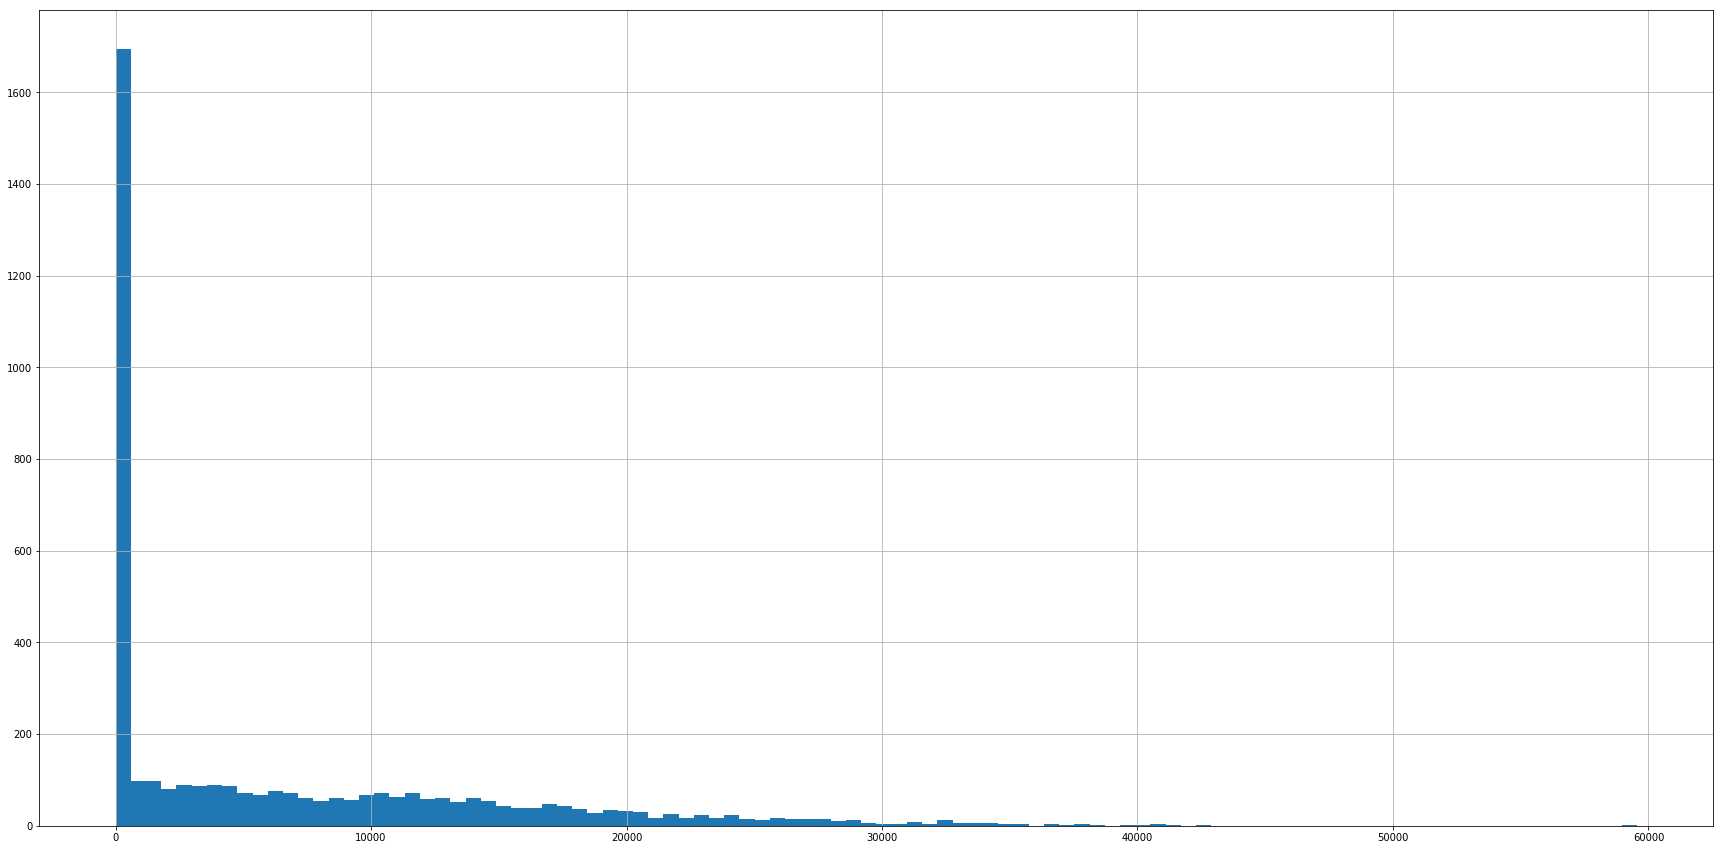

In [149]:
# pres_sum_fil = pres_sum[pres_sum>0]
pres_sum.hist(bins=100, figsize=(30,15))

In [146]:
presence_df.shape

(4096, 86400)

#### Load a PRESENCE.csv with locations cache (saved from the DB_TO_DETECTIONS notebook)

In [5]:
#TODO: make this a parametrized version of the previous 
#Loading the csv of intermediate result (saved from prevoius cell)
#example value: "/mnt/storage/janek/caches/Presence/PRESENCE-2016-08-23_00_num_hours_24_int_size_120.csv"

#NOTE: the presence cache does not yet know what bees it contains! 
(csv_name, csv_path) = create_presence_locations_cache_filename(num_hours, datetime_start, num_intervals_per_hour)
print('Starting with '+csv_path)
presence_locations_df = pd.read_csv(csv_path, dtype=object).iloc[:,1:]
#NOTE: save and read csv adds a duplicate index column, which has to be removed with iloc
#TODO: find a cleaner way to to solve that

#Load more Presence.csv days, in addition to the one we already loaded 
for i in tqdm(range(1, num_days_to_process)):
    
    start_day = datetime_start+timedelta(days=i)
    
    (csv_name, csv_path) = create_presence_locations_cache_filename(num_hours, start_day, num_intervals_per_hour)
    file = Path(csv_path)
    if file.exists() == False:
        print("File "+ csv_name + "Doesn't exist, stopping entire operation")
        break
    new_presence_locations_df = pd.read_csv(csv_path, dtype=object).iloc[:,1:]
    presence_locations_df = pd.concat([presence_locations_df, new_presence_locations_df])
print("Done, final shape: " + str(presence_locations_df.shape))

Starting with ../../caches/Presence/locations/PRESENCE-2016-07-20_00_num_hours_24_int_size_60.csv


100%|██████████| 59/59 [02:41<00:00,  2.73s/it]

Done, final shape: (245760, 1441)


### Applying rolling median to filter presence table

In [6]:
#Preparing for rolling median
num_nans_to_clean = math.floor(rolling_window_size/2)

#apply copies of the first and last column as offset to prepare for the rolling window
first_col = presence_df.iloc[:, 1:2]
last_col = presence_df.iloc[:, -1:]

presence_df_with_offset = presence_df.iloc[:, 1:]

for i in range(0,num_nans_to_clean):
    presence_df_with_offset = pd.concat([first_col, presence_df_with_offset, last_col] ,axis=1)
    

# Applying rolling median window, to filter out noise in the dataframe
rolled = presence_df_with_offset.rolling(window=rolling_window_size,center=True,axis=1).median()

#clean up to get rid of the NaNs
rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]

In [7]:
num_intervals_per_day = int(rolled.shape[0]/num_days_to_process)

In [39]:
rolled.shape
rolled.to_csv(cache_location_prefix+'Other/'+'all_bees_presence_rolled.csv')

In [40]:
rolled.shape

(245760, 1440)

In [9]:
presence_combined = rolled.iloc[:num_intervals_per_day,:]
for i in tqdm(range(2, num_days_to_process)):
    presence_combined = presence_combined + rolled.iloc[(i-1)*num_intervals_per_day:i*num_intervals_per_day,:]
presence_combined

100%|██████████| 58/58 [00:01<00:00, 56.39it/s]


,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0


1901

In [33]:
presence_combined.sum(axis=0).min()

17378.0

In [34]:
presence_combined.sum(axis=0).max()

22199.0

In [38]:
presence_combined.sum(axis=0).mean()

19203.793055555554

In [66]:
pres_stat_df = (presence_combined.sum(axis=0) / int(rolled.shape[0])).to_frame()
pres_stat_df.columns = ['id']

In [71]:
pres_stat_df

,id
0,0.071611
1,0.073059
2,0.073576
3,0.074166
4,0.074247
5,0.074207
6,0.074023
7,0.074849
8,0.074300
9,0.079419


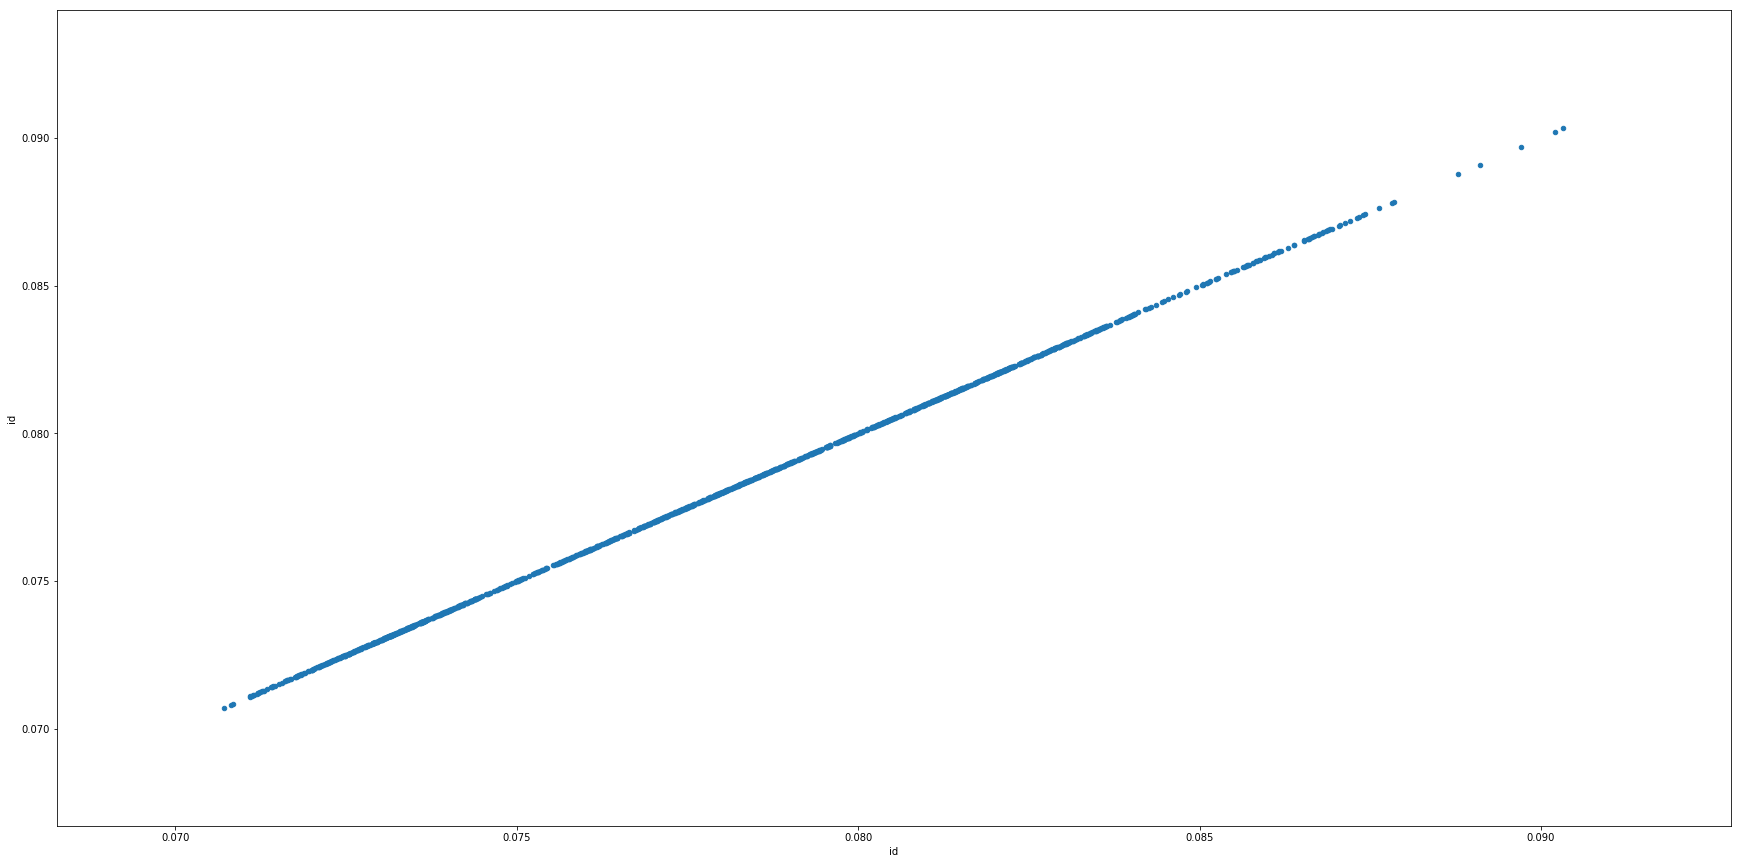

In [70]:
pres_stat_df.plot.scatter(figsize=(30,15), x=0,y=0)

### Getting trip lenghts for each bee

In [ ]:
#TODO: do we really need a variable for total_num_intervals? (test rolled_shape, it might have the same information)
#TODO: might be broken unless total_num_intervals is improved on or eliminated 
rolled_trip_lengths = calc_trip_lengths(rolled, total_num_intervals)

In [52]:
rolled.head()

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#use diff to identify beeentries (with 1) and beeexits (with -1)
#(sum_of_abs / 2) gives us the presumed number of trips a bee takes 

diffed = rolled.diff(axis=1)
diffed.iloc[:,0] = np.zeros([len(rolled_trip_lengths),1]) #clean out a column of NaNs 
summed = diffed.abs().sum(axis=1) / 2
trips_df = presence_df['id'] #for combining results in one table

In [11]:
#TODO: add comments explaining purpose

#for loop config
bin_starttime = datetime_start
num_intervals_per_bin = num_intervals_per_hour*bin_size_in_hours
total_num_bins = int(num_hours / bin_size_in_hours)

print("num_intervals_per_bin: ", num_intervals_per_bin, "total_num_bins: ", total_num_bins)
for bin_nr in range(total_num_bins): 
    
    start_index = bin_nr*num_intervals_per_bin
    end_index = start_index + num_intervals_per_bin
    
    new_bin = diffed.iloc[:, start_index:end_index]
    
    #limit down to the right bin:
    #read num_intervals_per_hour*bin_size_per_hour columns (as each column represents one interval)
    
    summed = new_bin.abs().sum(axis=1) / 2
    summed.name = bin_nr
    trips_df = pd.concat([trips_df,summed],axis=1) #add this interval to the trips table
    #update loop index
    

# TODO:use a new variable instead of reusing it
# Change values to amount per hour instead of per interval
trips_df = trips_df * 3600 / num_intervals_per_hour

num_intervals_per_bin:  1440 total_num_bins:  1


In [12]:
#TODO: is this the state we want to save?
#saving (name still incomplete)
date_string = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"

trips_df.to_csv(cache_location_prefix+'TRIPS-'+date_string+'-'+'h'+'.csv')


#### Plot 1: Histogram of the distribution of trip lenghts

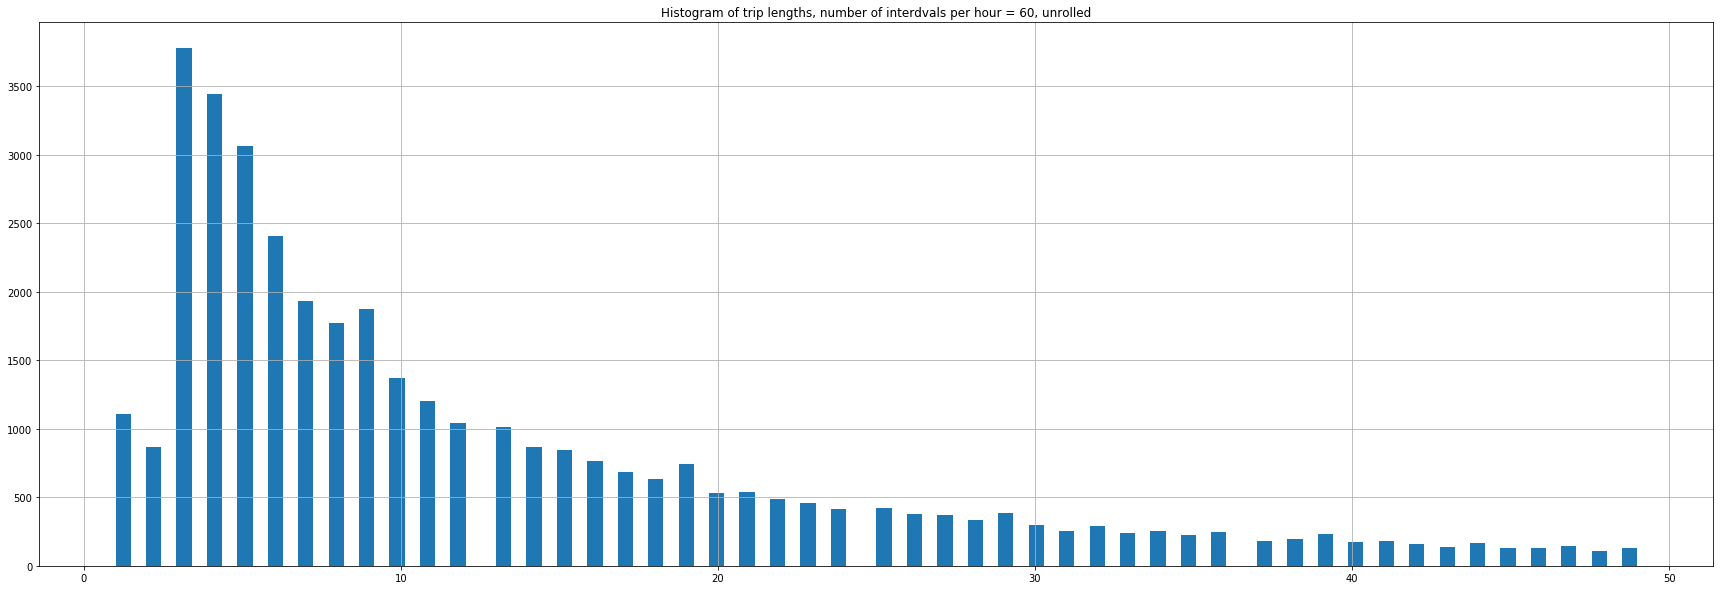

In [13]:
flat_list = [item for sublist in rolled_trip_lengths for item in sublist]
flat_series = pd.Series(flat_list)

ax = plt.figure(figsize=(30,10))
plt.title('Histogram of trip lengths, number of interdvals per hour = '+str(num_intervals_per_hour)+', unrolled')
(flat_series[flat_series<50]/num_intervals_per_minute).hist(log=False, bins=100)
# ax.set_xlabel('Number of intervals')
# ax.set_ylabel('Number of trips with a given length')

#### Plot 1a: Histogram of the distribution of trip lenghts, cut off at >50

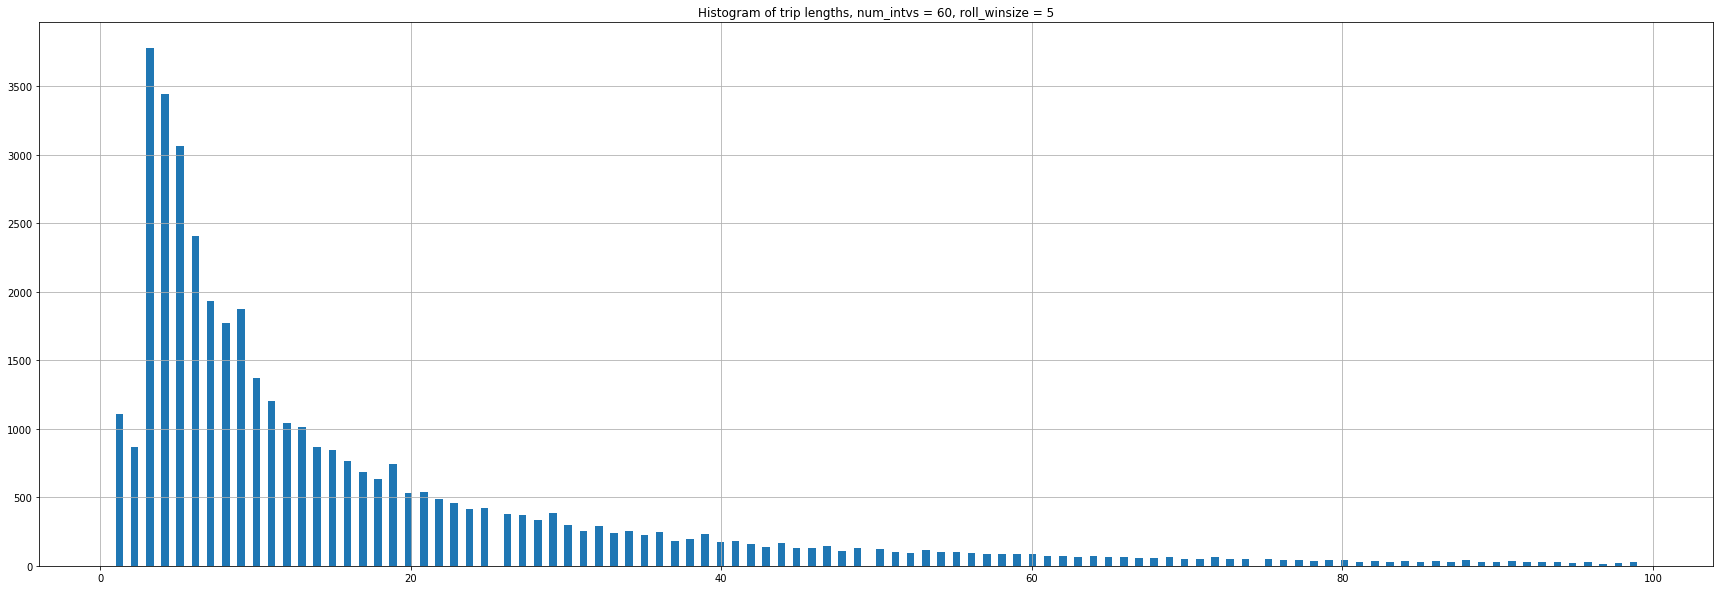

In [14]:
plt.figure(figsize=(30,10))
plt.title('Histogram of trip lengths, num_intvs = '+str(num_intervals_per_hour)+', roll_winsize = '+str(rolling_window_size)+'')
flat_series_filtered = flat_series[flat_series<100]
(flat_series_filtered/num_intervals_per_minute).hist(bins=200, log=False)

#### Plot 2: bee age vs amount of trips

In [22]:
#TODO: calculate ages from the dataframe later (after filtering)
bee_days_since_birth = [] 
bee_bdays = [] 

for i in tqdm(range(num_days_to_process)):
    start_day = datetime_start+timedelta(days=i)
    for id in bee_ids_as_beesbookid_format:
        bee_bdays.append(meta.get_hatchdate(id))
        bee_days_since_birth.append((start_day - meta.get_hatchdate(id)).days)

100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


In [23]:
#Create dataframe with age and amount of trips
summed = summed.reset_index(drop=True)
summed_age=pd.concat([pd.Series(bee_days_since_birth),summed],axis=1)
summed_age.columns=['age','amount']

summed_age = summed_age[summed_age['age'] > 0]
summed_age = summed_age[summed_age['amount'] > 0]

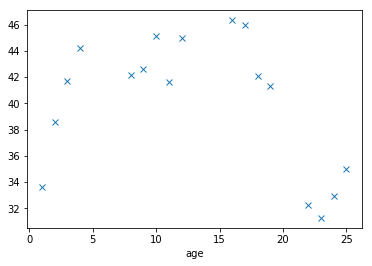

In [24]:
summed_age = summed_age.groupby('age')['amount'].mean()

# Plot amount of trips relative to age of bee
summed_age.plot(x='age',y='amount',style='x')

#### Plot 2a: bee age vs average trip lenght

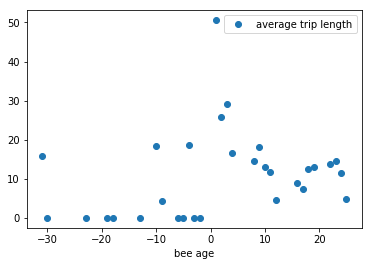

In [25]:
avg_trip_lengths = []
for lenghts in rolled_trip_lengths:
    if len(lenghts) == 0:
        avg_trip_lengths += [0]
    else:
        avg = np.average(lenghts)
        avg_trip_lengths += [avg]

avg_trip_lengths_with_age = pd.concat([pd.Series(bee_days_since_birth),pd.Series(avg_trip_lengths)], axis=1)
avg_trip_lengths_with_age.columns=['bee age','average trip length']

avg_trip_lengths_with_age = avg_trip_lengths_with_age.groupby('bee age')['average trip length'].mean().reset_index()

# Convert triplength from intervals to minutes
avg_trip_lengths_with_age['average trip length'] = avg_trip_lengths_with_age['average trip length']/num_intervals_per_minute

avg_trip_lengths_with_age.plot(x='bee age',y='average trip length',style='o')

#### Plot 3: heatmap (histogram) of amount of trip lengths by age 

In [26]:
#Creating empty dataframe for the amount of triplengths occuring for each age of the bees
triplength_age_df=pd.DataFrame(0, index=sorted(list(set(bee_days_since_birth))), columns=sorted(list(set(flat_list))))

#Creating a Counter which holds the amount of triplengths for each bee
counts = Counter()
for bee in range (len(bee_days_since_birth)):
    counts[bee] = Counter(rolled_trip_lengths[bee])
    
    
for counter_index in range(len(bee_days_since_birth)):
    for counter_triplength, counter_amount in counts[counter_index].items():
        triplength_age_df.loc[bee_days_since_birth[counter_index], counter_triplength] += counter_amount



In [27]:
triplength_age_df = triplength_age_df.drop(pd.np.nan)
#converting intervalls to minutes
triplength_age_df.columns = triplength_age_df.columns/num_intervals_per_minute
triplength_age_df.head(100)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,820.0,899.0,946.0,1019.0,1069.0,1139.0,1259.0,1262.0,1284.0,1299.0
-31.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
-30.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-23.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-19.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-18.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-13.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-10.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
-9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


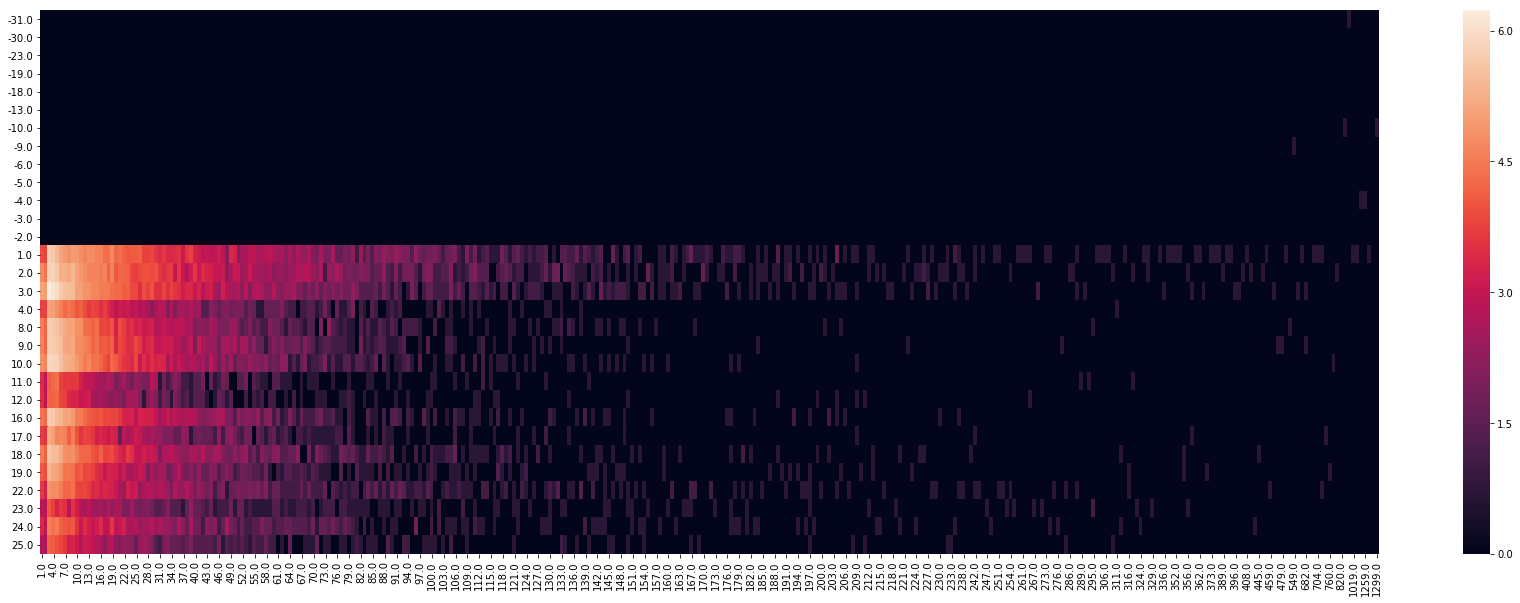

In [28]:
a = np.log1p(triplength_age_df)
plt.figure(figsize=(30,10))
sns.heatmap(a, annot=False, fmt=".1f")
#TODO: create also a normalized version of the heatmap (divide values by amount of bees with that age)

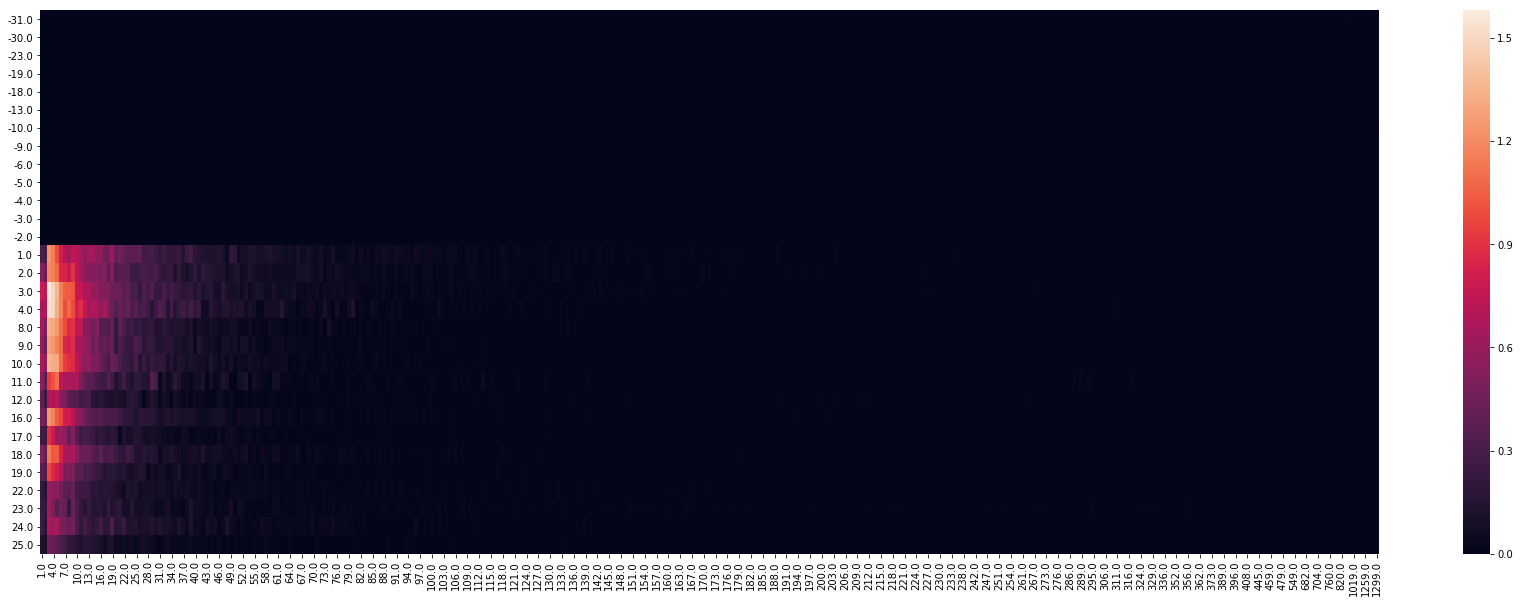

In [29]:
#Normalized by number of bees with that specific age 
triplength_age_normalized_df = triplength_age_df

ages = []
for age in triplength_age_normalized_df.index:
    ages.append(1/bee_days_since_birth.count(age))

triplength_age_normalized_df = triplength_age_normalized_df.mul(ages, axis=0)

plt.figure(figsize=(30,10))

sns.heatmap(np.log1p(triplength_age_normalized_df), annot=False, fmt=".1f")

#### Plot 4: boxplot of amount of trip lengths by age 

In [30]:
# dependency of counts, might be needed to be moved up to work with multiple dataframes
boxplot_df = pd.DataFrame()
for age in counts:
    if len(sorted(counts[age].elements()))>0:
        temp = pd.DataFrame({
            bee_days_since_birth[age]:sorted(counts[age].elements())})
        if bee_days_since_birth[age] in boxplot_df.columns:
            boxplot_df = boxplot_df.append(temp, ignore_index=True)
        else:
            boxplot_df = pd.concat([boxplot_df, temp], axis=1)
boxplot_df = boxplot_df.reindex(sorted(boxplot_df.columns), axis=1)

#rearranging the NaNs to the bottom
arr = boxplot_df.values
arr.sort(axis=0)
#converting intervals to minutes
boxplot_df = boxplot_df/num_intervals_per_minute
boxplot_df = pd.DataFrame(arr, index=boxplot_df.index, columns=boxplot_df.columns).dropna(axis=0, how="all")
boxplot_df

,-31.0,-10.0,-9.0,-4.0,1.0,2.0,3.0,4.0,8.0,9.0,...,12.0,16.0,17.0,18.0,19.0,22.0,23.0,24.0,25.0,nan
0,946.0,899.0,549.0,1139.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NaN,1299.0,NaN,1259.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
9,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


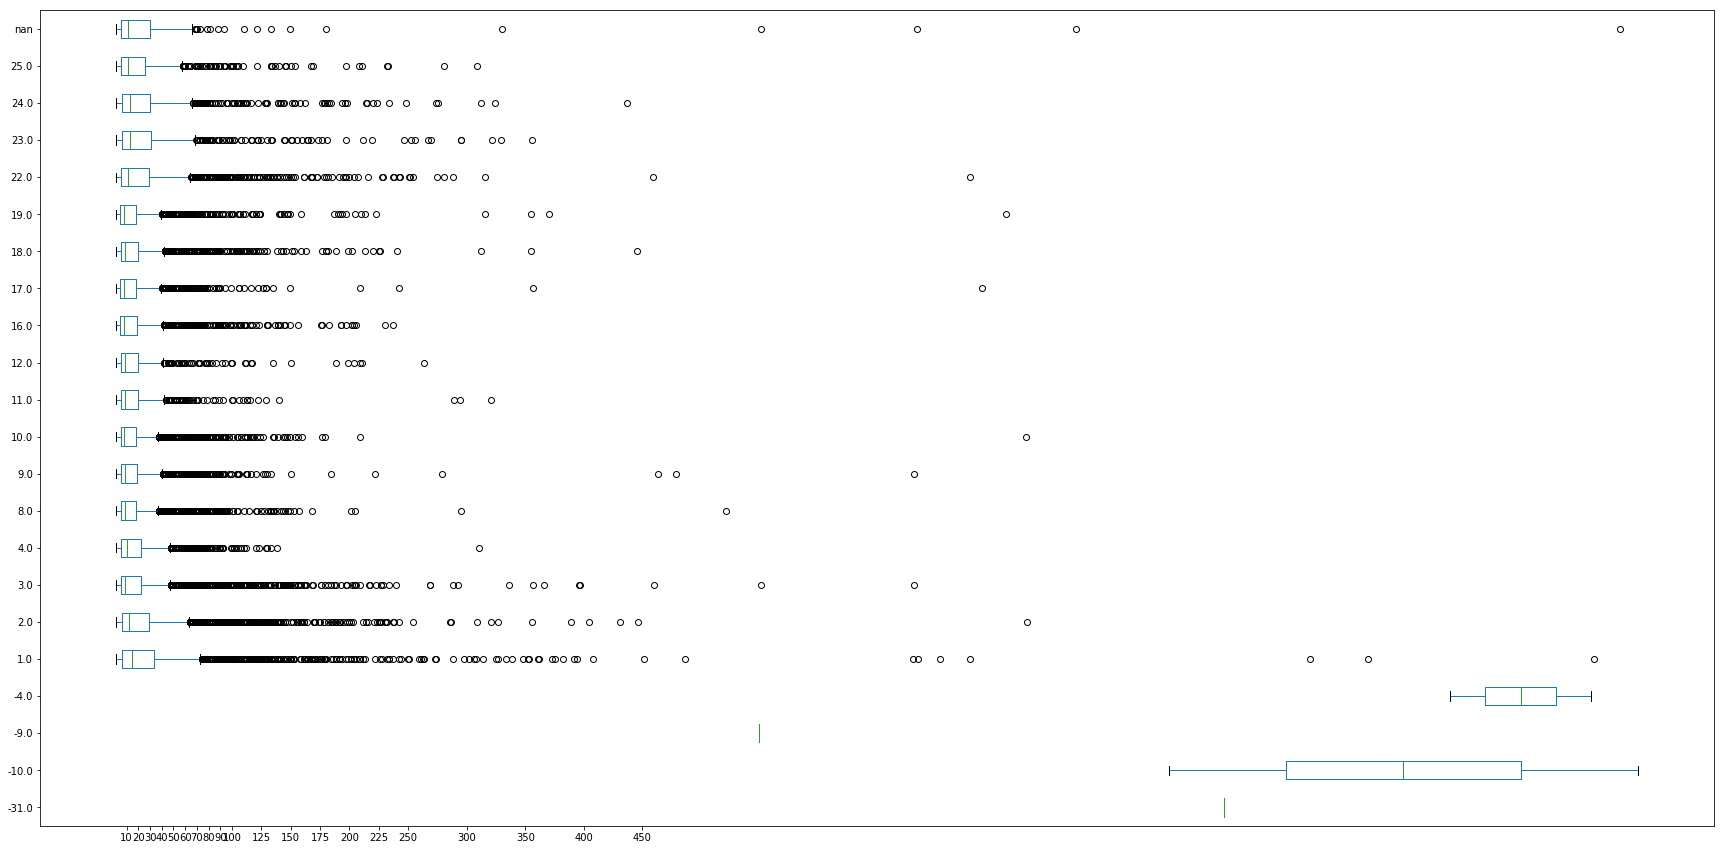

In [31]:
boxplot_df.plot.box(xticks=[10,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,300,350,400,450], figsize=(30,15),vert=False)

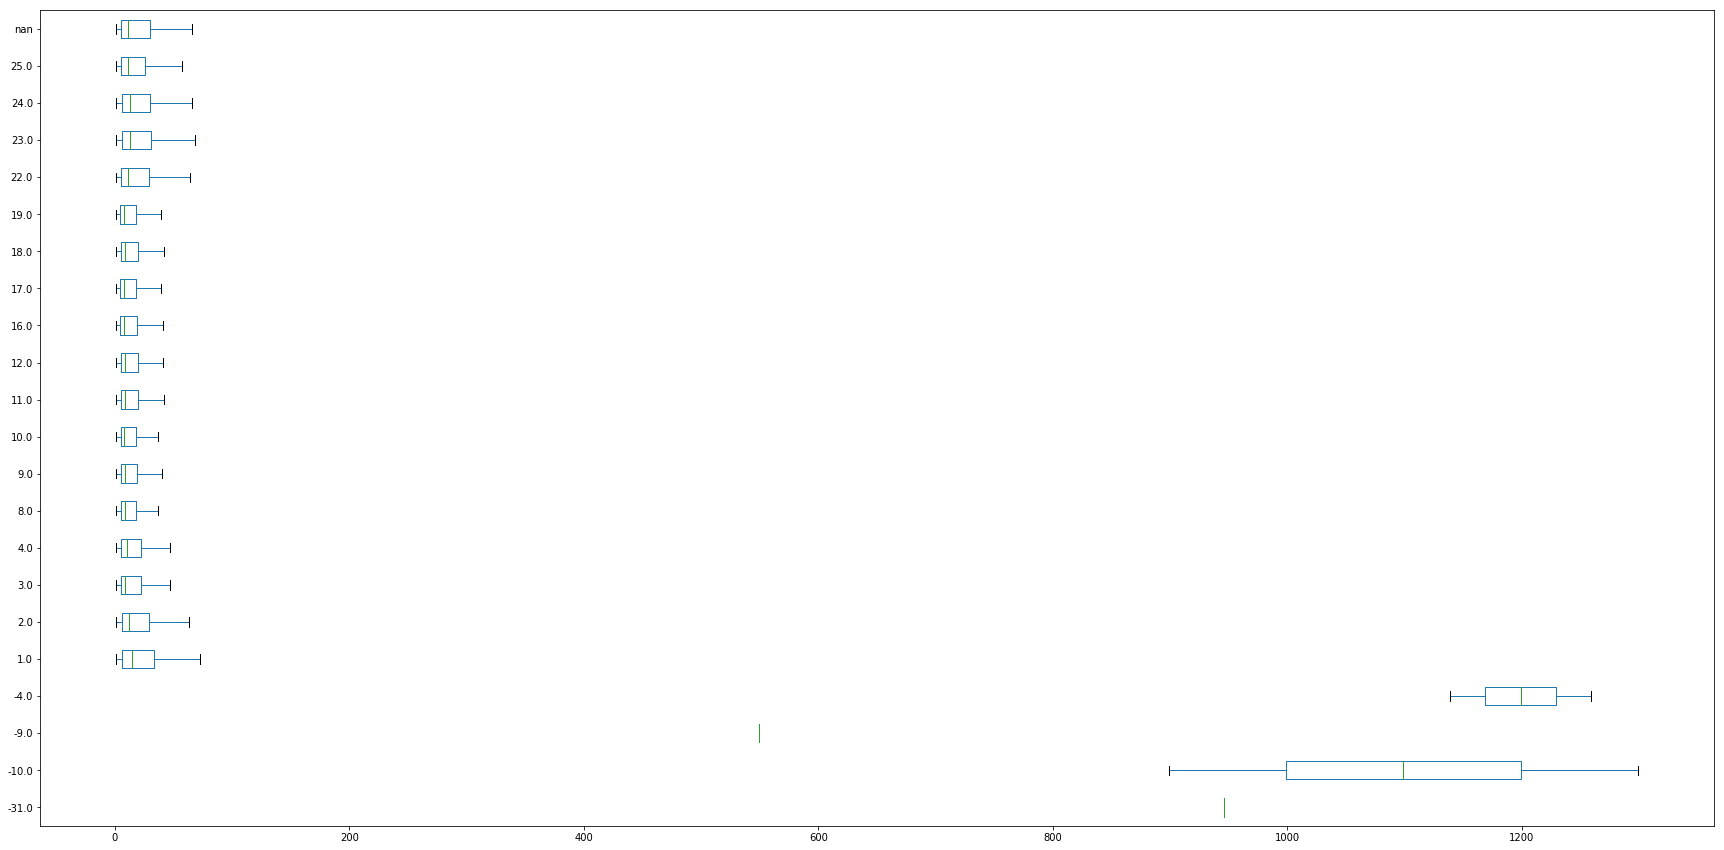

In [32]:
boxplot_df.plot.box(sym="", figsize=(30,15),vert=False)

### Heatmap for Hivecoordinates when starting trips by amount

In [33]:
trip_starts = calc_trip_starts(rolled, total_num_intervals)

In [34]:
# create coordinate dataframe
coordinate_df = pd.DataFrame(index=range(0,400),columns=range(0,250))
coordinate_sub_10_df = pd.DataFrame(index=range(0,400),columns=range(0,250))
coordinate_sub_20_df = pd.DataFrame(index=range(0,400),columns=range(0,250))
coordinate_sub_30_df = pd.DataFrame(index=range(0,400),columns=range(0,250))
coordinate_sub_40_df = pd.DataFrame(index=range(0,400),columns=range(0,250))
coordinate_above_40_df = pd.DataFrame(index=range(0,400),columns=range(0,250))

coordinate_df[:] = 0
coordinate_sub_10_df[:] = 0
coordinate_sub_20_df[:] = 0
coordinate_sub_30_df[:] = 0
coordinate_sub_40_df[:] = 0
coordinate_above_40_df[:] = 0
# travers trip_starts and lookup the coordinates for the respective bee for each trip start - write it into the coordinate dataframe
for i in range(len(trip_starts)):
    for j in range(len(trip_starts[i])):
        #print(i, trip_starts[i][j],  end=' ')
        if presence_locations_df.iat[i,trip_starts[i][j]] != "0.0" and "," in presence_locations_df.iat[i,trip_starts[i][j]]:
            temp=presence_locations_df.iat[i,trip_starts[i][j]]
            coordinates=[int(s) for s in temp.replace("(","").replace(")","").replace(",","").replace("-","").split() if s.isdigit()]
            coordinate_df.iat[coordinates[0],coordinates[1]] +=1
            if bee_days_since_birth[i] < 10 :
                coordinate_sub_10_df.iat[coordinates[0],coordinates[1]] +=1
            elif bee_days_since_birth[i] < 20 :
                coordinate_sub_20_df.iat[coordinates[0],coordinates[1]] +=1
            elif bee_days_since_birth[i] < 30 :
                coordinate_sub_30_df.iat[coordinates[0],coordinates[1]] +=1
            elif bee_days_since_birth[i] < 40 :
                coordinate_sub_40_df.iat[coordinates[0],coordinates[1]] +=1
            elif bee_days_since_birth[i] >= 40 :
                coordinate_above_40_df.iat[coordinates[0],coordinates[1]] +=1
# plot the coordinate dataframe

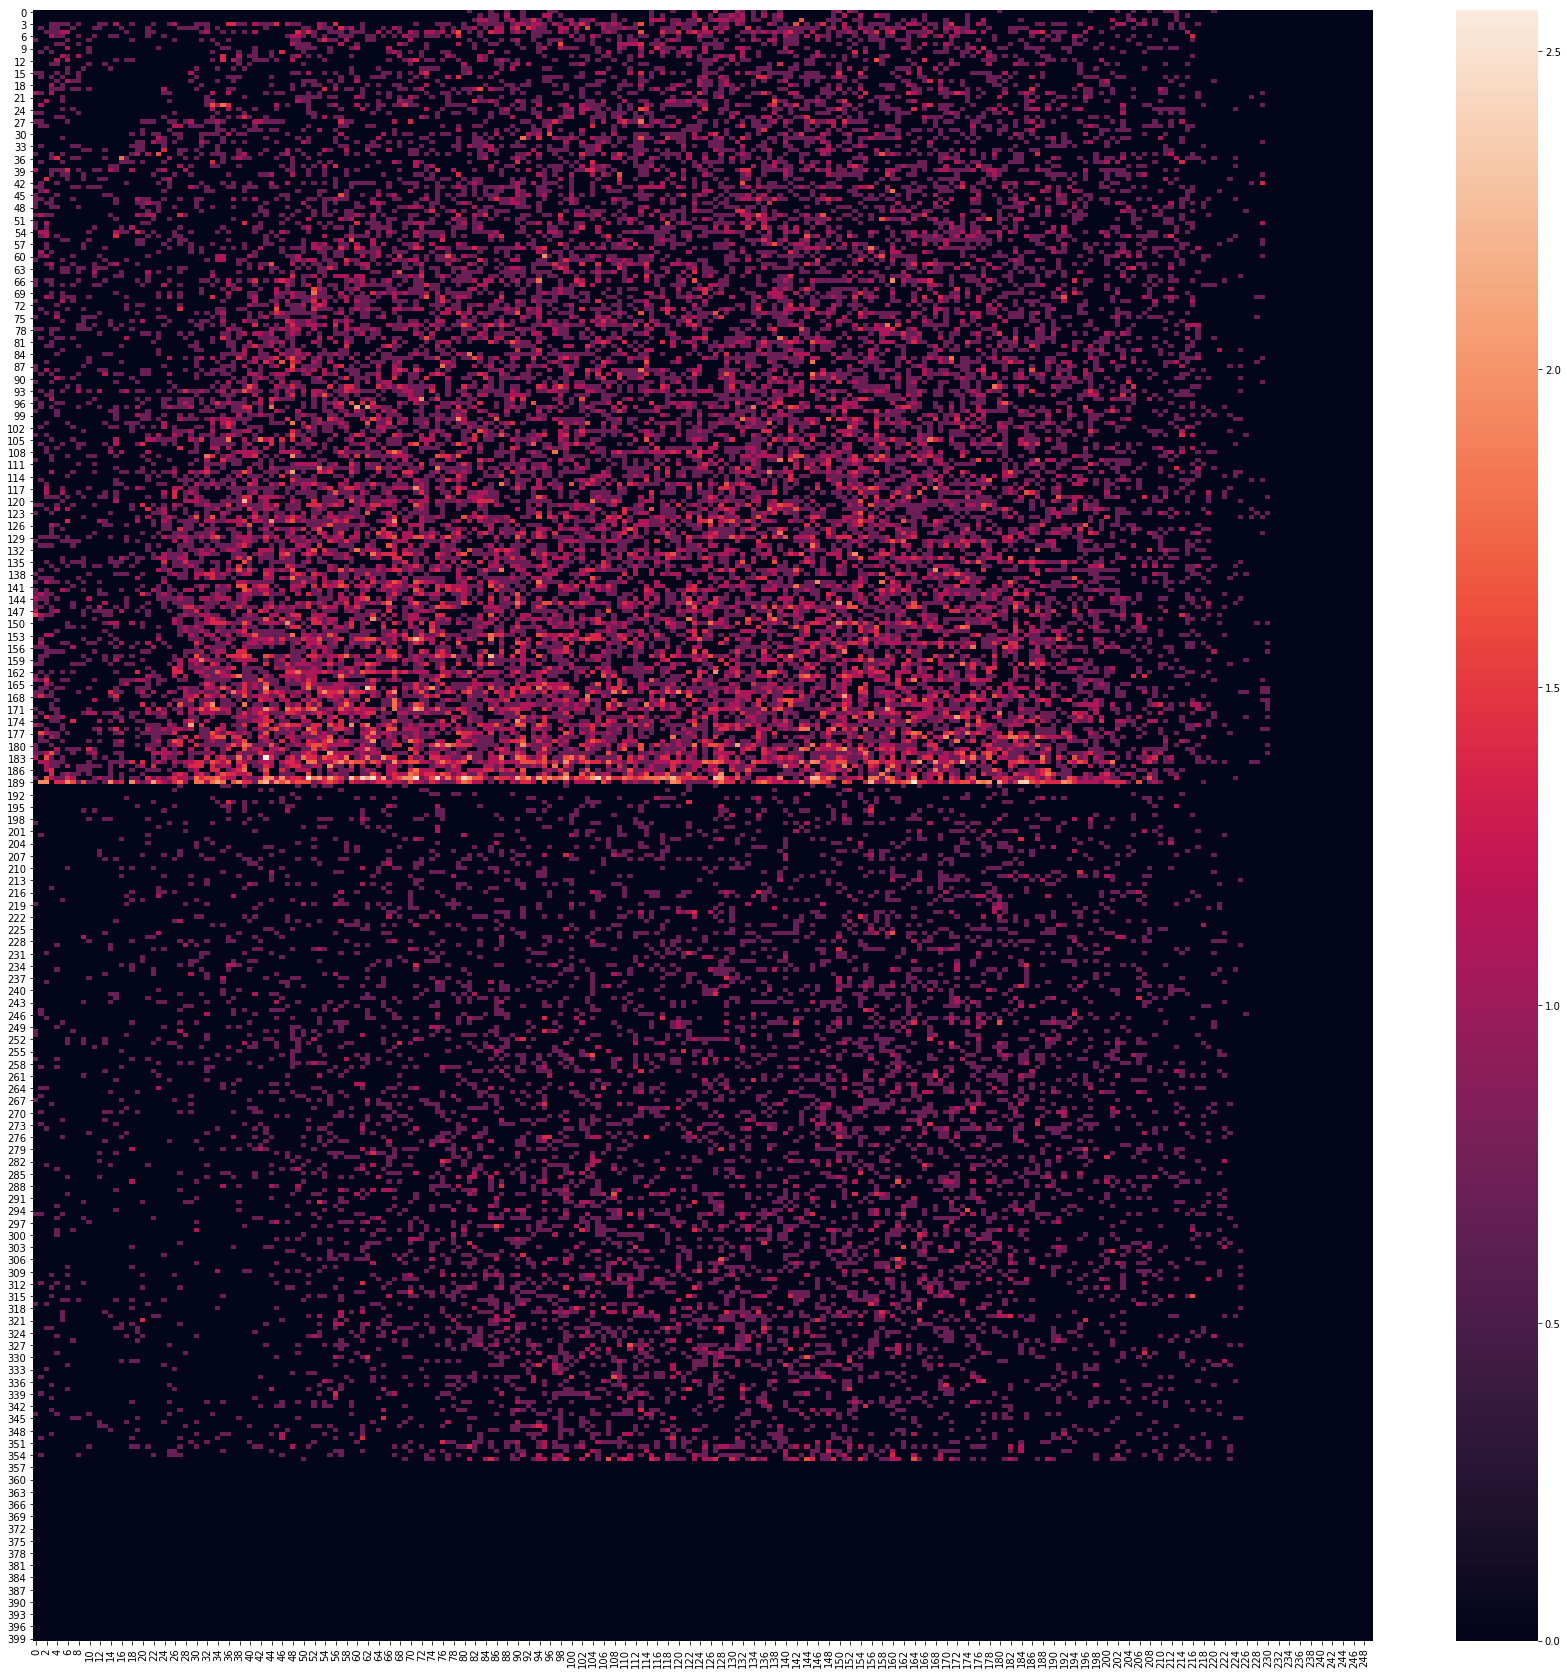

In [35]:
plt.figure(figsize=(30,30))

sns.heatmap(np.log1p(coordinate_df), annot=False, fmt=".1f")
#sns.heatmap(coordinate_df, annot=False, fmt=".1f")

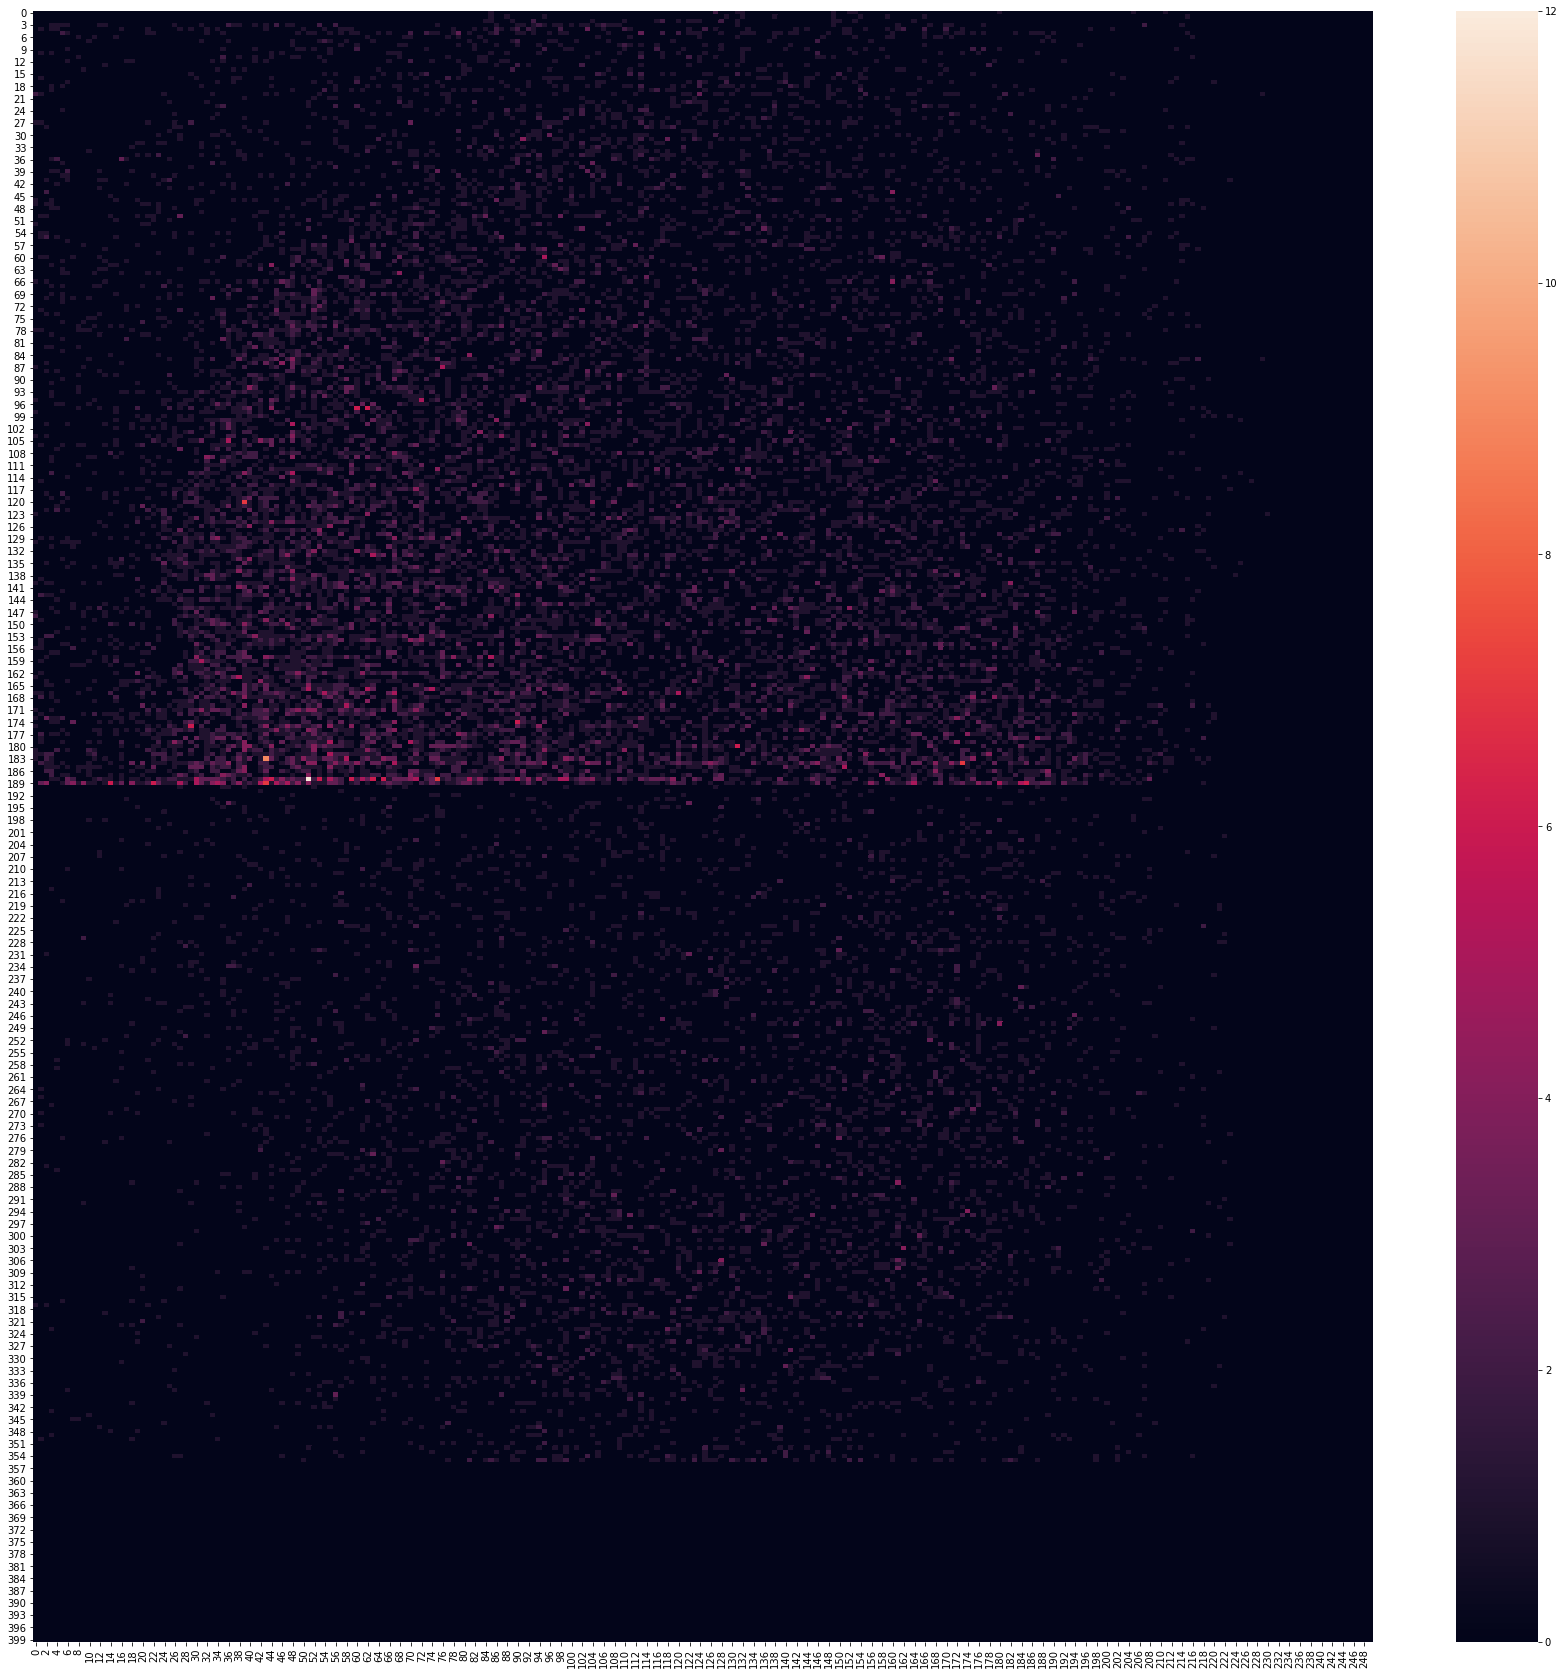

In [36]:
plt.figure(figsize=(30,30))

#sns.heatmap(np.log1p(coordinate_sub_10_df), annot=False, fmt=".1f")
sns.heatmap(coordinate_sub_10_df, annot=False, fmt=".1f")

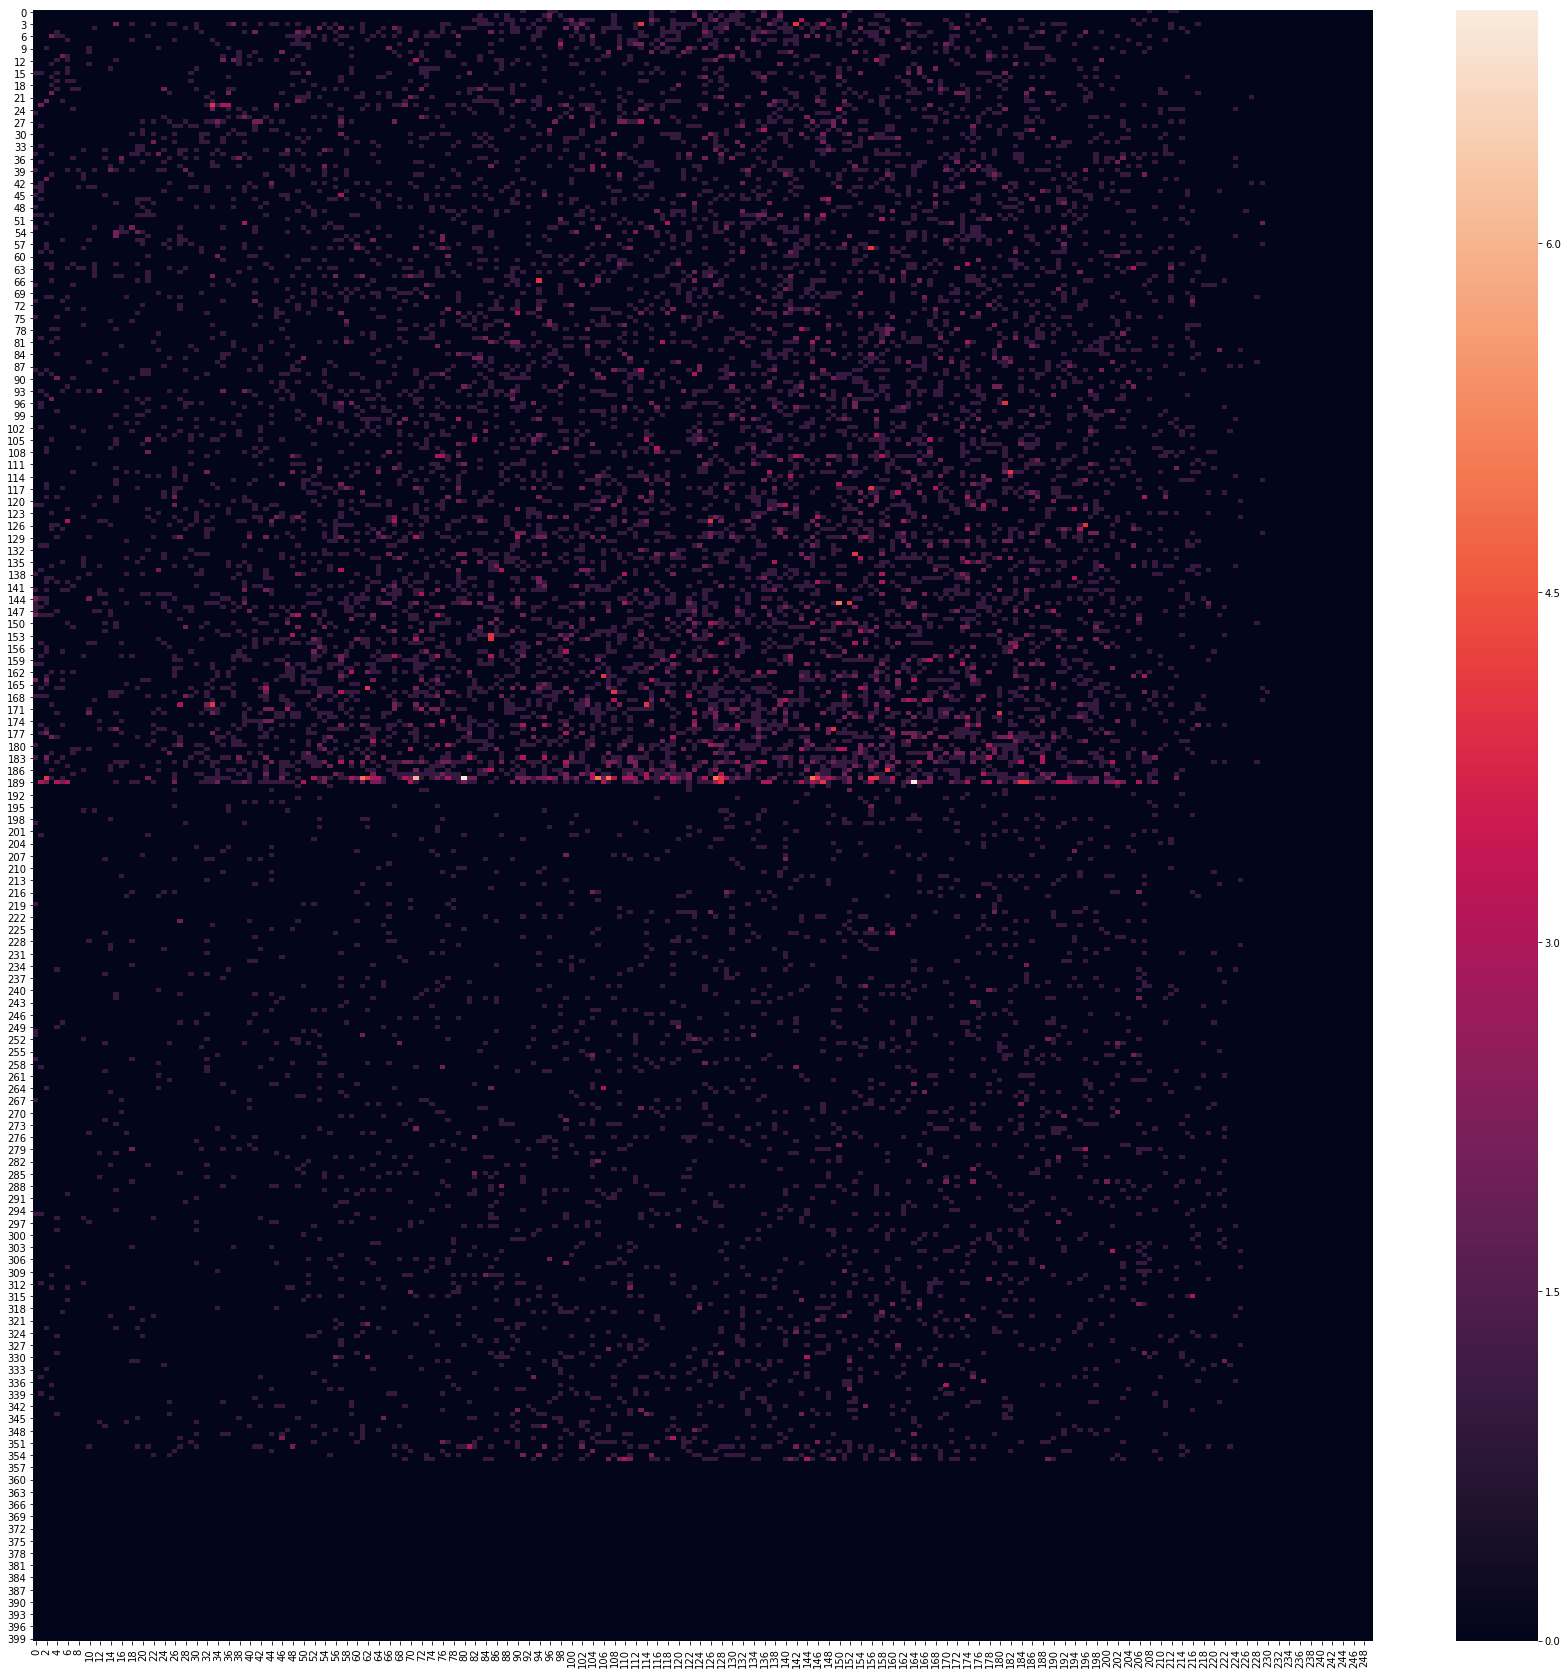

In [37]:
plt.figure(figsize=(30,30))

#sns.heatmap(np.log1p(coordinate_sub_20_df), annot=False, fmt=".1f")
sns.heatmap(coordinate_sub_20_df, annot=False, fmt=".1f")

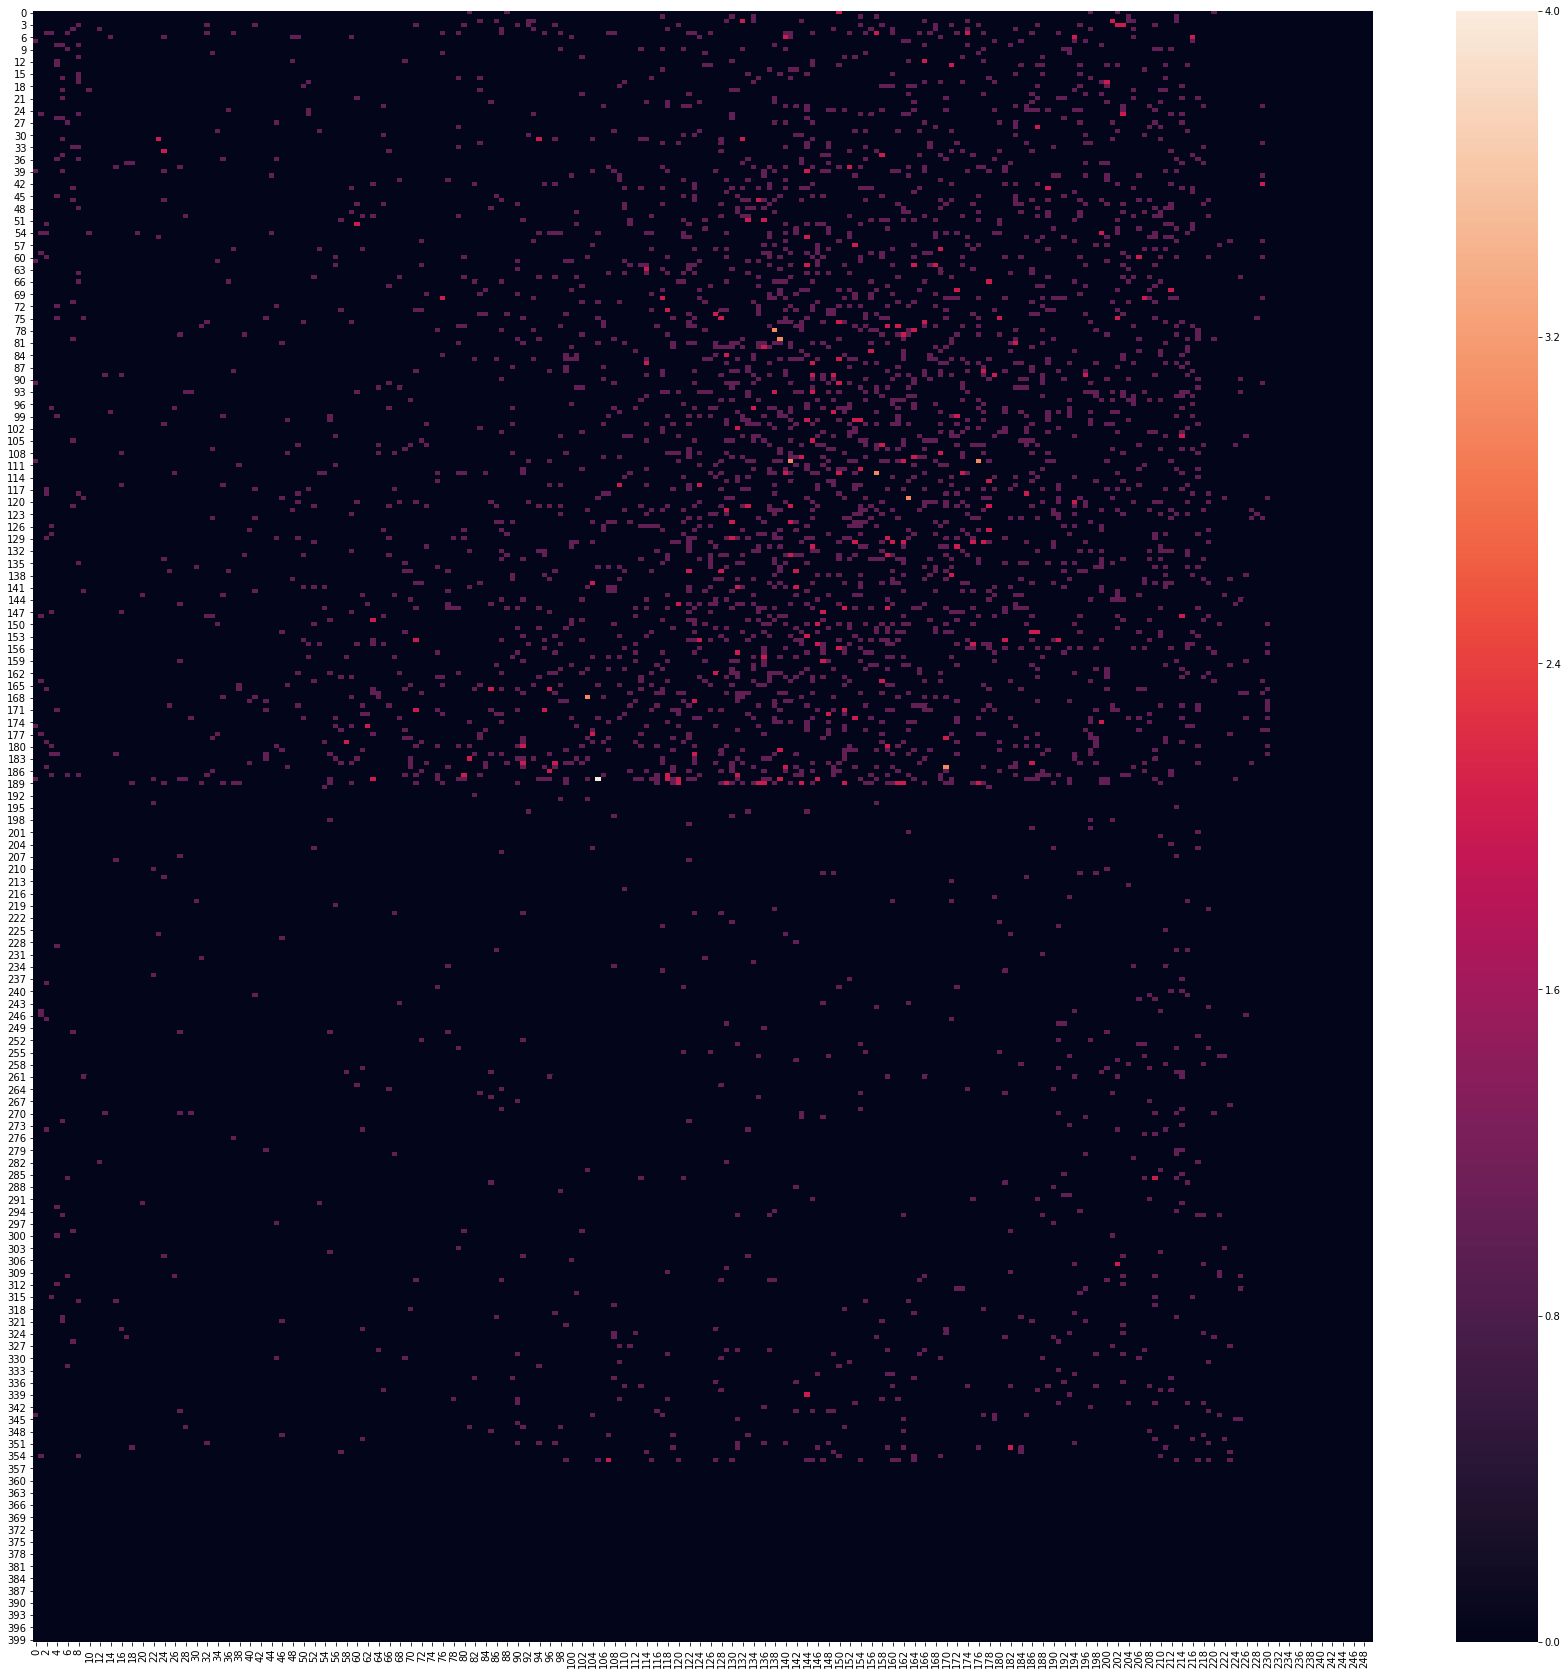

In [38]:
plt.figure(figsize=(30,30))

#sns.heatmap(np.log1p(coordinate_sub_30_df), annot=False, fmt=".1f")
sns.heatmap(coordinate_sub_30_df, annot=False, fmt=".1f")

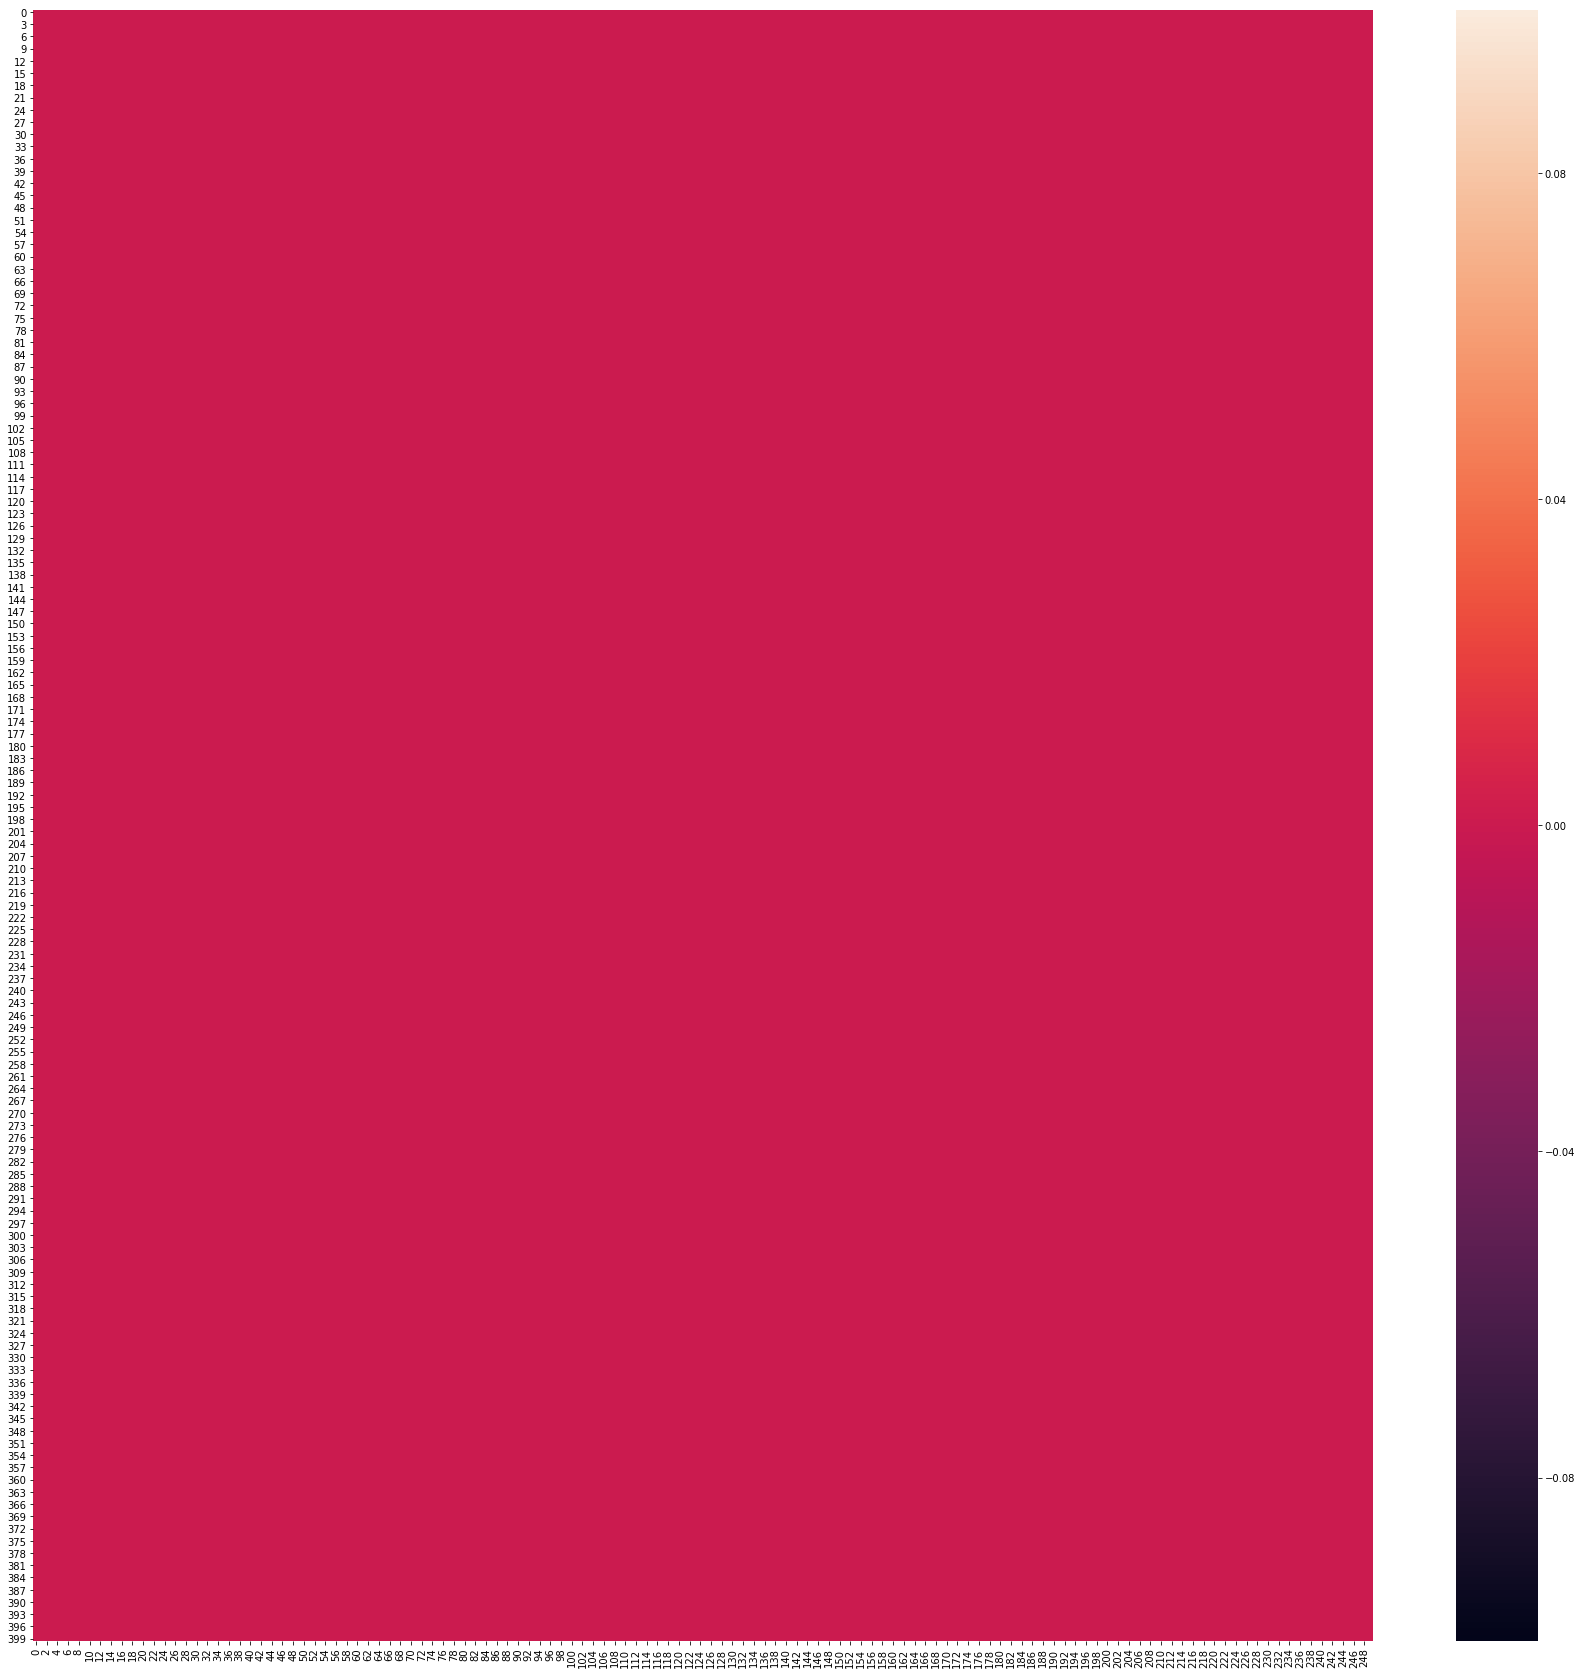

In [39]:
plt.figure(figsize=(30,30))

#sns.heatmap(np.log1p(coordinate_sub_40_df), annot=False, fmt=".1f")
sns.heatmap(coordinate_sub_40_df, annot=False, fmt=".1f")

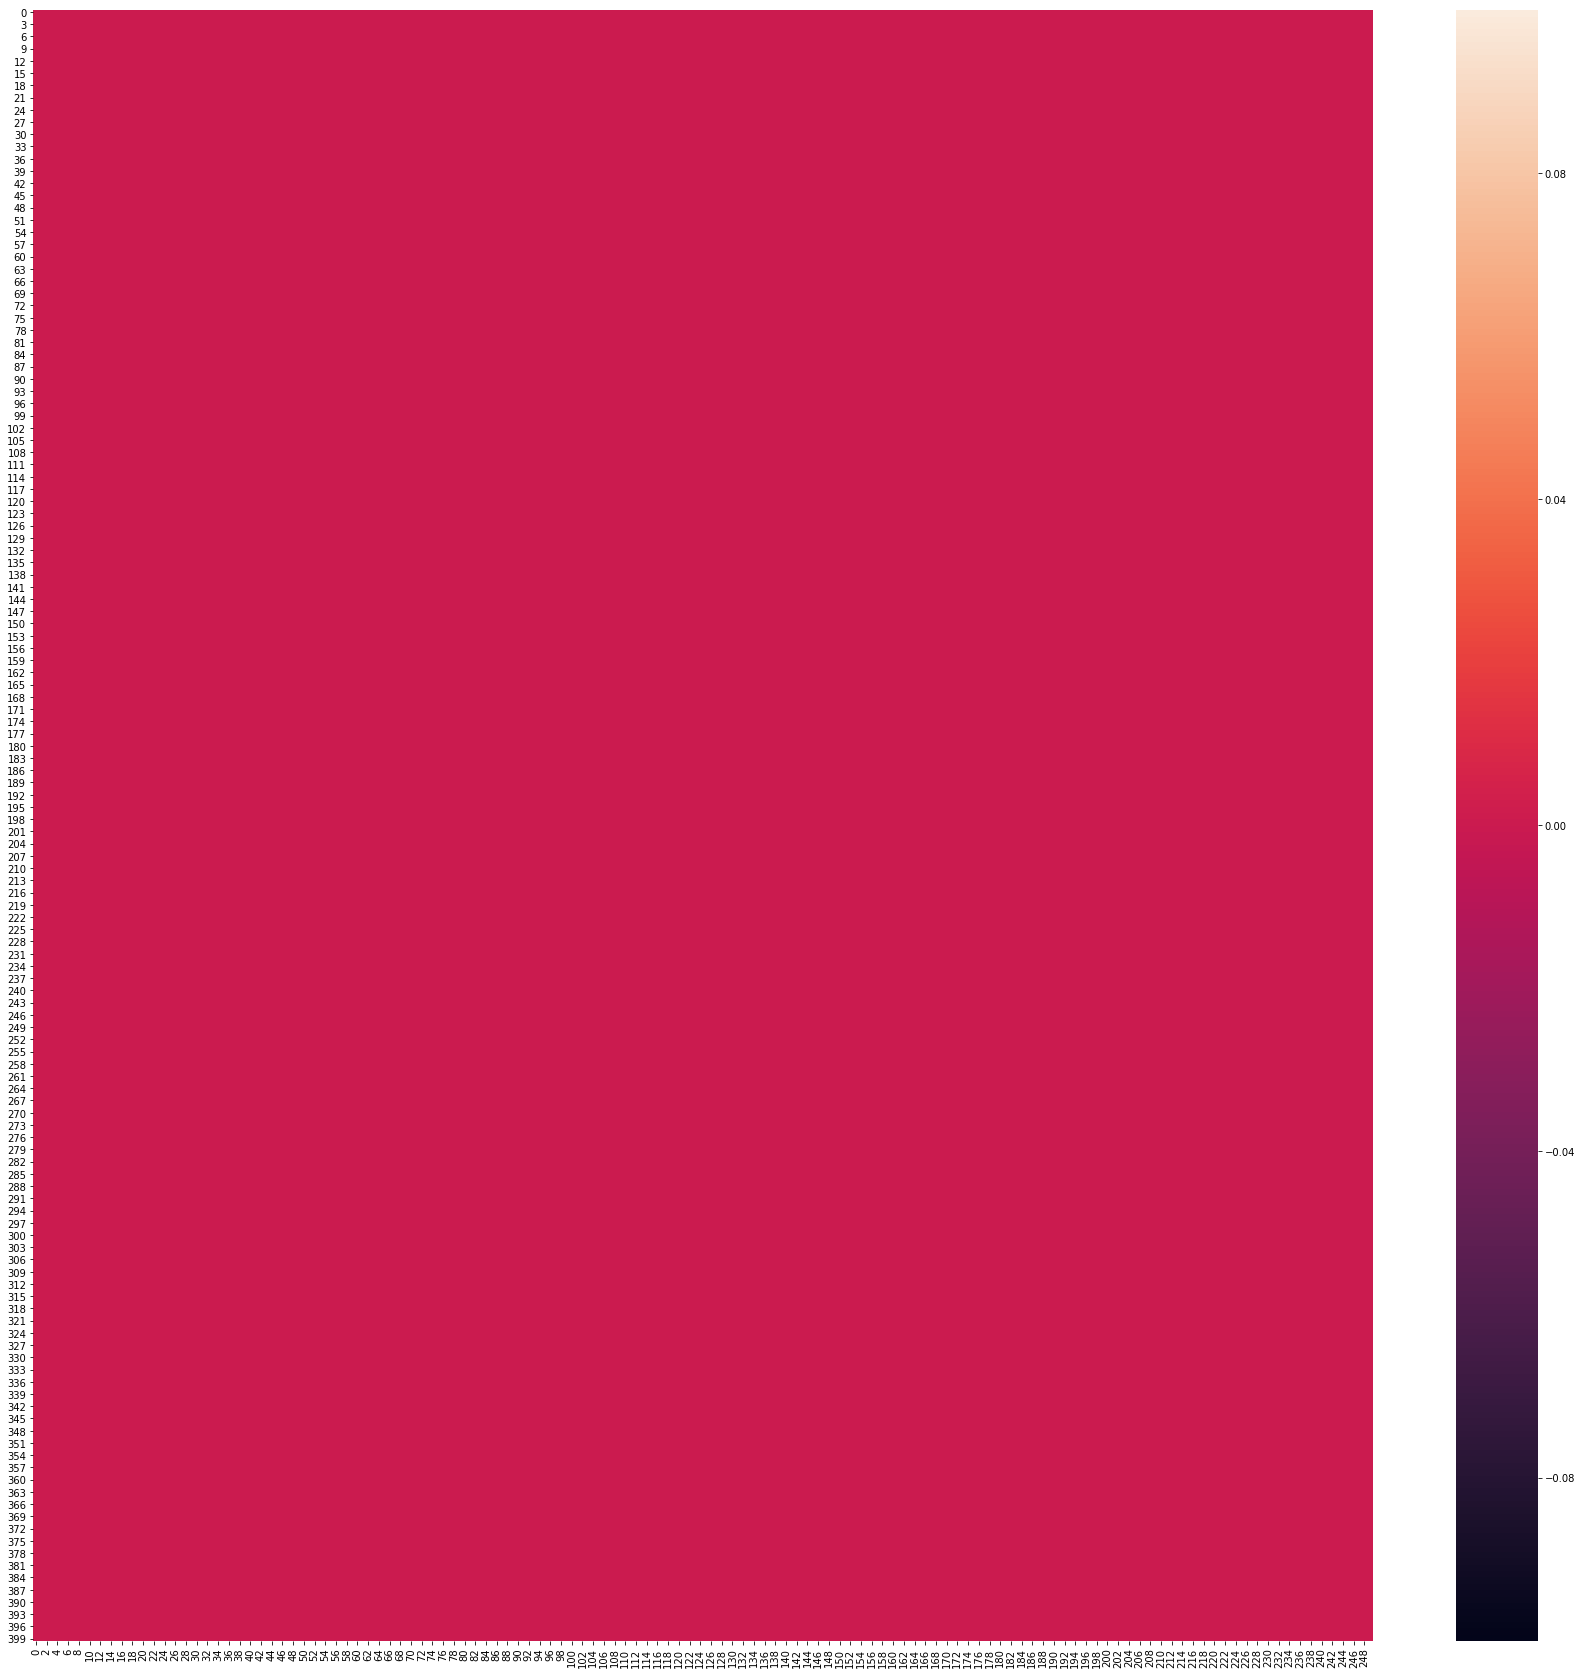

In [40]:
plt.figure(figsize=(30,30))

sns.heatmap(np.log1p(coordinate_above_40_df), annot=False, fmt=".1f")
#sns.heatmap(coordinate_above_40_df, annot=False, fmt=".1f")

## List of Variables

### Import Variables

connect_str : String data for accessing the database

meta        : contains meta data from bb_utils about bees that is used to get the data about forager bees

### Parameters

num_hours                    : Number of hours loaded from the database (int)

datetime_start               : Starting point in the database (Datetime(y,m,d,h))

bin_size_in_hours            : TBD

num_intervals_per_hour       : How many intervals for a single hour the dataframes will have (int)

rolling_window_size          : How big is the window for the rolling median function to filter noise (int)

total_num_intervals          : How many intervals are there in total - calculated with the product of num_hours and num_intervals_per_hour

group_id                     : ID of the forager group of bees that gets loaded 

bee_ids_as_beesbookid_format : Bee IDs from the chosen forager group in beesbookid format

bee_ids_from_group           : Bee IDs from the chosen forager group in ferwa format (which is also used in the database)

bee_days_since_birth         : Age of every chosen bee (Array of Int)

csv_path        : Filepath to csv file with the presence dataframe, containing the bee ids and their detections within given intervalls for a given timeframe (Str)

date_string                  : Filename for saving trips_df into a csv file


### Dataframes

presence_df             : contains the Bee IDs and and their detections (0 or 1) within given intervalls for a given amount of hours, starting from datetime_start

presence_df_with_offset : presence_df with rolling_window_offset times copied first and last column, so the rolling median operation doesn't calculate NaN values. Used copies of the first and last column as neutral elements, since all 0s or 1s could have caused false information about trip starts or endings

rolled                  : presence_df table after the filtering of noise with a rolling median window

diffed                  : dataframe that only contains 1 and -1 for each bee when a trip starts or ends - calculated by the diff function applied to the rolled dataframe

diffed_with_id          : diffed dataframe with an additional column containing the bee ids

diffed_with_age         : diffed dataframe with an additional column containing the bee ages

trips_df                : dataframe containing the amount of trips for each bee for each hour

triplength_age_df       : dataframe containing the amount of each occuring triplength in relation to the age of the bees

### to be named

trip_lengths            : List of trip lengths for each bee (List of Lists of Int)

curr_bee_trip_lenghts   : List of trip lengths for current bee (List of Int)

curr_trip_length        : amount of trips for the current bee within the loop; used to prevent appending empty lists to trip_lengths (Int)

bool_is_present         : 0 or 1 depending wether the bee has a detection within an interval or not (boolean)

flat_list               : Conversion of trip_lengths into a normal list containing all the triplengths (List of Int)

flat_series             : Conversion of flat_list into pd.Series (Series of Int)

rolling_window_offset   : Size of the offset required for the rolling window to each side of the center - calculated by the floor of the windowsize devided by 2 (Int)

first_col               : first column of presence_df, is used to duplicate it for the rolling_window_offset (Series of Int)

last_col                : last column of presence_df, is used to duplicate it for the rolling_window_offset (Series of Int)

counts                  : Array of Counters which contain the triplength and the amount. Each Position in the array represents one element of bee_days_since_birth (meaning one                                 certain age)

In [41]:
# caching the diffed tables - one time only
#diffed = diffed.reset_index()
#for i in range(num_days_to_process):
#    print(i*4096, i*4096+4095)
#    temp_cache_df = diffed.loc[i*4096:i*4096+4095,:]
#    date_string = (datetime_start + timedelta(days=i)).strftime("%Y-%m-%d_%H")
#    csv_name = 'Diffed-'+str(date_string)+"_num_hours_"+str(num_hours)+"_int_size_"+str(num_intervals_per_hour)+'.csv'
#    temp_path = "../caches/Diffed/"+csv_name
#    temp_cache_df.to_csv(temp_path)
#    print(temp_path)

In [42]:
test_loc_x_df = presence_locations_df.copy()
test_loc_x_df.loc[:,:] = 0.0
test_loc_y_df = presence_locations_df.copy()
test_loc_y_df.loc[:,:] = 0.0
for i in range(len(trip_starts)):
    for j in range(len(trip_starts[i])):
        #print(i, trip_starts[i][j],  end=' ')
        if presence_locations_df.iat[i,trip_starts[i][j]] != "0.0" and "," in presence_locations_df.iat[i,trip_starts[i][j]]:
            temp=presence_locations_df.iat[i,trip_starts[i][j]]
            coordinates=[int(s) for s in temp.replace("(","").replace(")","").replace(",","").replace("-","").split() if s.isdigit()]
            test_loc_x_df.iat[i,trip_starts[i][j]] = coordinates[0]
            test_loc_y_df.iat[i,trip_starts[i][j]] = coordinates[1]
print(test_loc_x_df.replace(0,np.NaN).mean(axis=1))
print(test_loc_y_df.replace(0,np.NaN).mean(axis=1))

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9       125.828571
10      125.617647
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17       84.666667
18             NaN
19             NaN
20             NaN
21      136.093023
22      131.000000
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
           ...    
4066           NaN
4067           NaN
4068           NaN
4069           NaN
4070           NaN
4071           NaN
4072           NaN
4073           NaN
4074           NaN
4075           NaN
4076           NaN
4077           NaN
4078           NaN
4079           NaN
4080           NaN
4081           NaN
4082           NaN
4083           NaN
4084           NaN
4085           NaN
4086           NaN
4087        

In [43]:
test = test_loc_y_df.replace(0,np.NaN).mean(axis=1)

In [38]:
test

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
5              NaN
6              NaN
7              NaN
8              NaN
9       118.085714
10      148.705882
11             NaN
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17      162.333333
18             NaN
19             NaN
20             NaN
21      145.674419
22      161.291667
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28             NaN
29             NaN
           ...    
4066           NaN
4067           NaN
4068           NaN
4069           NaN
4070           NaN
4071           NaN
4072           NaN
4073           NaN
4074           NaN
4075           NaN
4076           NaN
4077           NaN
4078           NaN
4079           NaN
4080           NaN
4081           NaN
4082           NaN
4083           NaN
4084           NaN
4085           NaN
4086           NaN
4087        